# Preamble : libraries import, function and class definition

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.special import boxcox1p
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Imputer, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [3]:
# encoder of categorical (object) features  to dummy features

from sklearn.base import BaseEstimator, TransformerMixin

class dummy_encoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cols = X.loc[:, X.dtypes == np.object].columns
        self.dummy_cols = pd.get_dummies(X, columns=self.cols).columns
        
        return self
    
    def transform(self, X):
        X_transformed = pd.get_dummies(X, columns=self.cols)
        X_transformed = X_transformed.reindex(columns=self.dummy_cols, fill_value=0)
        
        return X_transformed

In [4]:
# select best categorical columns (after transformation in dummy variables) 
# by choosing columns with lowest p-value from ANOVA test

class anova_best_p_selector(BaseEstimator, TransformerMixin):
    def __init__(self, k_best=None, p_limit=10**(-5)):
        self.p_limit = p_limit
        self.k_best = k_best
        
    def fit(self, X, y):
        # select dummy columns
        X_cat = X.filter(regex='_')
        # append target value to X
        df = X_cat.join(y)
        # select column name for y value
        self.target_col = df.columns[-1]
        
        # create a dataframe to write F-scores and p-values
        self.ANOVA_cat_cols = pd.DataFrame(columns=['F', 'p'])
        
        for col in X_cat.columns:
            pivot_df = df.pivot(columns=col, values=self.target_col)

            group_cols = pivot_df.columns
            groups = []
            for group_col in group_cols:
                groups.append(pivot_df[group_col].dropna())

            F, p = stats.f_oneway(*groups)
            self.ANOVA_cat_cols.loc[col, 'F'] = F
            self.ANOVA_cat_cols.loc[col, 'p'] = p
        
        if self.k_best == None:
            # select worst columns of p-value above p_limit
            ANOVA_cat_cols_worst = self.ANOVA_cat_cols[ANOVA_cat_cols.p > self.p_limit]
            self.worst_cols = ANOVA_cat_cols_worst.index
        
        else:
            # select k_best worst columns of highest p-value
            ANOVA_cat_cols_sorted = self.ANOVA_cat_cols.sort_values(by='p')
            self.worst_cols = ANOVA_cat_cols_sorted.index[self.k_best:]
        
        return self
    
    def transform(self, X):
        # drop the worst columns
        X_transformed = X.drop(self.worst_cols, axis=1)

        return X_transformed

In [5]:
def multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test, grid_cv=5):
    '''
    gridsearch for all estimators given to the function and return different metrics for the training, CV and test set
    
    preprocess_steps : list of preprocessing steps
    estimators : list of estimators who will be append to the pipeline after the preprocessing steps
    params_list : list of dictionnary of parameters for the gridsearch 
    X_train, y_train : for the grid search with Cross validation
    X_test, y_test : to test the best model found by gridsearch
    
    output : dataframe of results, dictionnary of best estimators
    '''
    
    def get_params_grids(estimators, params_list):
        '''
        input : - estimators : list of estimators 
                - params_list : list of dictionnary of parameters for gridsearch

        ouptut : return a dictionnary of dictionnary of parameters for the gridsearch : estimators -> parameters -> values
                ready to be inserted in multi_estimators_gridsearch
        '''
        params_grids = {}
        for estimator, param_grid in zip(estimators, params_list):
            estimator_name = estimator.__class__.__name__

            params = {}
            for key in param_grid:
                params[estimator_name.lower() + '__' + key] = param_grid[key]
            params_grids[estimator] = params
        return params_grids
    
    params_grids = get_params_grids(estimators, params_list)
    
    
    # set results dataframe
    estimators_cols = ['Parameters', 'Train Score Mean', 'CV Score Mean',
                       'Test Score Mean', 'CV Score STD' , 'Test RMSE', 'Fitting Time Mean']
    estimators_results = pd.DataFrame(columns = estimators_cols)
    estimators_results.index.name = 'Estimator Name'
    
    best_estimators = {}
    for estimator in estimators:

        #make pipeline : preprocess + estimator
        estimator_pipe = make_pipeline(*preprocess_steps, estimator)
        
        param_grid = params_grids[estimator]

        gridsearch = GridSearchCV(estimator_pipe, param_grid=param_grid, cv=grid_cv)
        gridsearch.fit(X_train, y_train)
        # Cross-validation
        cv_results = cross_validate(gridsearch.best_estimator_, X_train, y_train, cv  = 2*grid_cv, return_train_score=True)

        #get estimator name
        estimator_name = estimator.__class__.__name__
        # write estimator parameter
        estimators_results.loc[estimator_name, 'Parameters'] = str(gridsearch.best_estimator_.steps[-1][1].get_params())
        # write training score mean
        estimators_results.loc[estimator_name, 'Train Score Mean'] = cv_results['train_score'].mean()
        # write CV score mean
        estimators_results.loc[estimator_name, 'CV Score Mean'] = cv_results['test_score'].mean()
        # write std of the CV scores
        estimators_results.loc[estimator_name, 'CV Score STD'] = cv_results['test_score'].std()

        # write test score
        estimators_results.loc[estimator_name, 'Test Score Mean'] = gridsearch.score(X_test, y_test)
        estimators_results.loc[estimator_name, 'Test RMSE'] = np.sqrt(mean_squared_error(y_test, gridsearch.predict(X_test)))
        
        # write estimator fit time mean
        estimators_results.loc[estimator_name, 'Fitting Time Mean'] = cv_results['fit_time'].mean()
        
        # append best estimator trained on the whole training set
        best_estimators[estimator_name] = gridsearch.best_estimator_
        
        print(estimator_name, 'DONE')
   
    return estimators_results, best_estimators

# 1. Data Cleaning 

In [6]:
#loading the dataset
housing = pd.read_csv('data/house-prices-advanced-regression-techniques/train.csv', index_col=0)
housing_submission = pd.read_csv('data/house-prices-advanced-regression-techniques/test.csv', index_col=0)
housing.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.2 Clean dataset of false nans and outliers
Here, I apply different transformation and cleaning function, to both the training and submission set.

In [7]:
# concat train and test set, to apply same cleaning transformation
X_full = pd.concat([housing.drop('SalePrice', axis=1), housing_submission])

In [8]:
# eda_num_cols = ['OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt','BsmtFinSF1','YearRemodAdd', 'MSSubClass']
# eda_cat_cols = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish']

# selected_cols = ['SalePrice'] + eda_num_cols + eda_cat_cols


# numerical and categorical columns selected during EDA
def column_selector(df, drop_cols=['LotFrontage']):
    return df.drop(drop_cols, axis=1)
#######################################
# Clean dataset of false nans by converting them to categorical value 'None'
def false_nan_to_cat(df):
    '''
    change nan values for the column in the list cols to the value 'None'
    '''
    cols_nan = df.isnull().sum()
    cols_with_nans = cols_nan[cols_nan>0].index
    #select false nans columns
    false_nan_cols = [col for col in cols_with_nans if col not in ['Electrical']] #['LotFrontage', 'Electrical']
    
    for col in false_nan_cols:
        df.loc[df[col].isnull(), col] = 0
    return df
#######################################
# transform numerical feature to categorical
def num_to_cat(df, cols=['MSSubClass']):
    for col in cols:
        df.loc[:, col] = df[col].astype(np.object)
    return df
#######################################

def normality_transf(df):
    
    skews = df.select_dtypes(['number']).skew()
    skewed_feats = skews[abs(skews) > 0.5]
    skewed_features = skewed_feats.index
    lam = 0.5
    for feat in skewed_features:
        df.loc[:, feat] = boxcox1p(df[feat], lam)
    return df
#######################################
# square some features
cols_deg2 = ['OverallQual', 'GarageCars', 'YearBuilt', 'YearRemodAdd','FullBath']
def deg2_features(df, cols_deg2=cols_deg2):
    for col in cols_deg2:
        df.loc[:, col+'_sq'] = df[col].pow(2)
    return df
#######################################
# clean dataset of outliers 
outliers = [524, 1299] # list of outliers Id, other potential outliers : 692, 1183
def remove_outliers(df, outliers=outliers):
    return df.drop(outliers, axis=0)
#######################################

# apply all cleaning and feature engeneering to dataframe
funcs_list = [column_selector, false_nan_to_cat, remove_outliers, num_to_cat, deg2_features, normality_transf]
def apply_cleaning_functions(df, funcs_list=funcs_list):
    for func in funcs_list:
        df = func(df)
    return df

housing_clean = apply_cleaning_functions(X_full)
y_clean = remove_outliers(housing.SalePrice)

### Get training and test set

In [9]:
# select predictors and target values and split into train and test set, we drop 'LotFrontage' because there 
# is too much missing values
y = np.log1p(y_clean)
X = housing_clean.loc[y.index,:]

encoder = dummy_encoder()
anova_selector = anova_best_p_selector(k_best=200)
X_encoded = encoder.fit_transform(X)
X_encoded_filtred = anova_selector.fit_transform(X_encoded, y)

X = X_encoded_filtred
print('X shape :', X_encoded_filtred.shape)


# the target values are then transformed to get a distribution closer to the normal distribution (see EDA)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# check nans values
X_nans = X.isnull().sum().sort_values(ascending=False)
print('X nans :', X.isnull().sum().sum())
print(X_nans[X_nans!=0])
print('-'*20)
print('y nans :', y.isnull().sum())

X shape : (1458, 234)
X nans : 0
Series([], dtype: int64)
--------------------
y nans : 0


# 2. In the search of the best model : Multiple Estimators gridsearch and results

## 2.1 Using EDA selected features

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# list of pre-processing steps
preprocess_steps = [Imputer(strategy='mean'), StandardScaler()]

# estimators to be used
kneigh = KNeighborsRegressor()
lin_reg = LinearRegression()
ridge_reg = Ridge()
lasso_reg = Lasso()
forest_reg = RandomForestRegressor()
gboost_reg = GradientBoostingRegressor()
xgb_reg = XGBRegressor()


#list of estimators
estimators = [
        kneigh,
        lin_reg,
        ridge_reg,
        lasso_reg,
        forest_reg,
        gboost_reg,
        xgb_reg,
         ]

# setting parameters for gridsearch
param_kneigh = {'n_neighbors':list(range(3,31,3))}
param_lin_reg = {}
param_ridge_reg = {'max_iter':[5000], 'alpha':np.logspace(0,3,10)}
param_lasso_reg = {'alpha':np.logspace(-5,1,10)}
param_forest_reg = {'n_estimators':[10,50,100]}
param_gboost_reg = {'n_estimators':[100,200], 'learning_rate':[0.01,0.1,1], 'loss':['ls', 'huber']}
param_xgb_reg = {'max_depth':[2,3,4], 'learning_rate':[0.01,0.1,0.5], 'n_estimators':[100,200]}

# list of parameters for each estimators
params_list = [param_kneigh, param_lin_reg, param_ridge_reg, param_lasso_reg, param_forest_reg, param_gboost_reg, param_xgb_reg]

# get results of best estimators found by gridsearch
estimators_results, best_models = multi_estimators_gridsearch(preprocess_steps, estimators, params_list, X_train, y_train, X_test, y_test)
estimators_results

KNeighborsRegressor DONE
LinearRegression DONE
Ridge DONE
Lasso DONE
RandomForestRegressor DONE
GradientBoostingRegressor DONE
XGBRegressor DONE


,Parameters,Train Score Mean,CV Score Mean,Test Score Mean,CV Score STD,Test RMSE,Fitting Time Mean
Estimator Name,,,,,,,
KNeighborsRegressor,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.841654,0.776583,0.751398,0.0466312,0.197621,0.0156105
LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",0.952677,-3.68531e+23,-5.65336e+18,1.07633e+24,9.424e+08,0.027268
Ridge,"{'alpha': 215.44346900318823, 'copy_X': True, ...",0.945453,0.913393,0.911587,0.0242335,0.117853,0.0168613
Lasso,"{'alpha': 0.0046415888336127772, 'copy_X': Tru...",0.939364,0.915818,0.925082,0.0273223,0.108486,0.10462
RandomForestRegressor,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",0.982183,0.871279,0.877723,0.0275248,0.138597,1.46543
GradientBoostingRegressor,"{'alpha': 0.9, 'criterion': 'friedman_mse', 'i...",0.982222,0.898475,0.91845,0.0210356,0.113186,0.726485
XGBRegressor,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.956047,0.900483,0.911086,0.0247103,0.118186,0.579106


## 2.2 Feature importance for the best model (Lasso)

Using Lasso, we can evaluate the importance of the different features by looking at their associated coefficient.

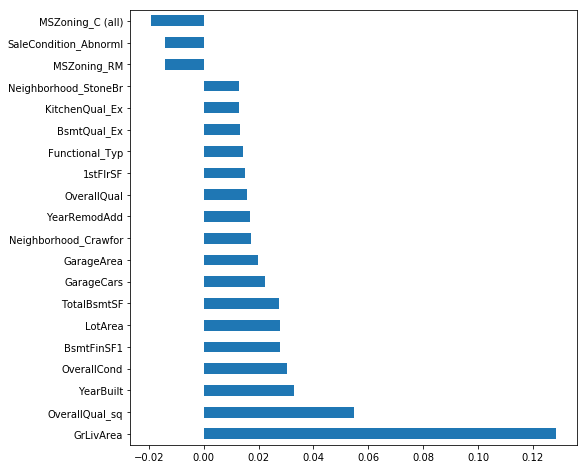

In [11]:
# select Lasso pipeline
best_lasso_pipe = best_models['Lasso']
# select the Lasso model
best_lasso = best_lasso_pipe.steps[-1][-1]
# select the coef of the Lasso model
lasso_coef = best_lasso.coef_

coef_df = pd.DataFrame({'Lasso Coef':lasso_coef}, index=X.columns)

coef_df['abs_coef'] = coef_df['Lasso Coef'].abs()
#select the 20 feature of highest absolute coefficient value
important_coef = coef_df.sort_values(by='abs_coef', ascending=False).head(20)
important_coef_sorted = important_coef.sort_values(by='Lasso Coef', ascending=False)
important_coef_sorted['Lasso Coef'].plot(kind='barh', figsize=(8,8));

Lasso has also a special behavior comparted to other linear model. The L1 regularization imposed by Lasso has the property of shrinking the coefficient of lesser importance to zero.

In [12]:
coef_zero = coef_df[coef_df['Lasso Coef']==0]
print('# features with coef = 0 :', len(coef_zero))
print('ex : ')
print(coef_zero.index)

# features with coef = 0 : 153
ex : 
Index(['MasVnrArea', 'BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtHalfBath', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'EnclosedPorch',
       ...
       'PoolQC_Ex', 'Fence_0', 'Fence_MnPrv', 'Fence_MnWw', 'MiscFeature_0',
       'MiscFeature_Shed', 'SaleType_COD', 'SaleCondition_AdjLand',
       'SaleCondition_Normal', 'SaleCondition_Partial'],
      dtype='object', length=153)


# 3. Submission

I select the best model, retrain it on the whole dataset, predict and prepare submission file for the Kaggle submission.

In [13]:
best_model_name = estimators_results['Test Score Mean'].idxmax()
best_model = best_models[best_model_name]
best_model.fit(X, y)

Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=0.0046415888336127772, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False))])

In [14]:
# prediction for competition set
X_submission = housing_clean.loc[housing_submission.index,:]

X_submission_encoded = encoder.transform(X_submission)
X_submission_transformed = anova_selector.transform(X_submission_encoded)

y_submission_pred = best_model.predict(X_submission_transformed)

y_comp_pred_final = np.exp(y_submission_pred) - 1
df_submission = pd.DataFrame({'SalePrice':y_comp_pred_final}, index=housing_submission.index)
df_submission.to_csv('submission.csv')